# Migration Network

In [104]:
import networkx as nx
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from layout import Layout

### Import and clean data
source: 

In [105]:
countries = pd.read_csv("mig_nodes.csv", index_col=0)
migration = pd.read_csv("mig_edges.csv")

In [120]:
countries

,name,code,region,sub_region,pos
index,,,,,
0,Afghanistan,4,Asia,Southern Asia,"array([1.83174148, 1.86242262])"
1,Albania,8,Europe,Southern Europe,"array([1.89105956, 2.05459683])"
2,Algeria,12,Africa,Northern Africa,"array([1.90130528, 1.98917661])"
3,American Samoa,16,Oceania,Polynesia,"array([1.97167436, 2.13972604])"
4,Andorra,20,Europe,Southern Europe,"array([1.70167317, 1.89743272])"
...,...,...,...,...,...
227,Wallis and Futuna Islands,876,Oceania,Polynesia,"array([1.79672158, 2.22175723])"
228,Western Sahara,732,Africa,Northern Africa,"array([2.01706011, 1.86488782])"
229,Yemen,887,Asia,Western Asia,"array([1.92891113, 1.97069976])"


In [106]:
migration["total"] = migration[["migration_1990_total","migration_1995_total","migration_2000_total","migration_2005_total","migration_2010_total","migration_2015_total"]].sum(axis=1)
migration = migration[migration["total"] != 0]

In [107]:
migration

,source,target,migration_1990_total,migration_1990_male,migration_1990_female,migration_1995_total,migration_1995_male,migration_1995_female,migration_2000_total,migration_2000_male,...,migration_2005_total,migration_2005_male,migration_2005_female,migration_2010_total,migration_2010_male,migration_2010_female,migration_2015_total,migration_2015_male,migration_2015_female,total
0,0,64,237,194,43,188,150,38,154,117,...,183,142,41,198,152,46,235,173,62,1195
1,0,118,677,556,121,452,351,101,236,155,...,259,187,72,284,206,78,320,231,89,2228
2,0,142,64,26,38,61,25,36,58,23,...,45,18,27,43,18,25,39,17,22,310
3,0,191,59,37,22,36,24,12,30,20,...,47,27,20,69,41,28,83,50,33,324
4,0,202,8485,3726,4759,12248,5518,6730,17118,7874,...,12636,5687,6949,8900,3906,4994,7587,3279,4308,66974
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11223,231,220,4767,2148,2619,7571,3451,4120,10686,4909,...,26585,12282,14303,42811,19381,23430,50001,22556,27445,142421
11224,231,11,8265,4184,4081,10498,5291,5207,12110,6110,...,21690,10960,10730,33720,16870,16850,38843,19418,19425,125126
11225,231,147,676,323,353,822,398,424,2807,1365,...,7794,3783,4011,8170,3959,4211,8416,4070,4346,28685
11226,231,68,0,0,0,0,0,0,0,0,...,0,0,0,6,6,0,6,6,0,12


### Writing Graph Layouts

In [108]:
G_tot = nx.DiGraph()
for _, row in migration.iterrows():
    G_tot.add_edge(row["source"], row["target"], weight=row["total"])
nx.info(G_tot)

'DiGraph with 232 nodes and 11159 edges'

In [109]:
G_1990 = nx.DiGraph()
for _, row in migration.iterrows():
    G_1990.add_edge(row["source"], row["target"], weight=row["migration_1990_total"])
nx.info(G_1990)

'DiGraph with 232 nodes and 11159 edges'

In [110]:
G_2015 = nx.DiGraph()
for _, row in migration.iterrows():
    G_2015.add_edge(row["source"], row["target"], weight=row["migration_2015_total"])
nx.info(G_2015)

'DiGraph with 232 nodes and 11159 edges'

In [107]:
pos = nx.spring_layout(G_tot, dim=3)

In [108]:
layout_tot = Layout(G_tot, pos, node_names=countries["name"])
layout_1990 = Layout(G_1990, pos, node_names=countries["name"])
layout_2015 = Layout(G_2015, pos, node_names=countries["name"])
layout_2015_comm = Layout(G_2015, pos, node_names=countries["name"])

In [109]:
region_colors = {
    'Africa': (0, 0, 0, 100),
    'Asia': (252, 177, 49, 100),
    'Europe': (0, 129, 200, 100),
    'Latin America and the Caribbean': (238, 51, 78, 100),
    'Northern America': (156, 39, 176, 100),
    'Oceania': (0, 166, 81, 100)
}

def continent_node_color(node):
    region = countries.loc[node, "region"]
    return region_colors[region]

continent_node_colors = [continent_node_color(node) for node in G_tot]
layout_1990.node_colors = continent_node_colors
layout_2015.node_colors = continent_node_colors

In [110]:
communities = nx.algorithms.community.greedy_modularity_communities(G_2015, weight="weight")
n_comms = len(communities)
colors = 100 * np.ones((n_comms, 4))
colors[:,:3] = np.array(sns.color_palette(n_colors=n_comms)) * 255
colors = colors.astype(int)

comm_node_colors = np.zeros((len(G_2015), 4))
for i, community in enumerate(communities):
    for node in community:
        comm_node_colors[node] = colors[i]

layout_2015_comm.node_colors = comm_node_colors

In [111]:
green = (56, 142, 60, 100)
red = (211, 47, 47, 100)
grey = (97, 97, 97, 100)

def net_node_color(G, node):
    in_deg = G.in_degree(node, weight="weight")
    out_deg = G.out_degree(node, weight="weight")
    net = in_deg - out_deg
    if net > 0:
        return green
    if net < 0:
        return red
    return grey

layout_tot.node_colors = [net_node_color(G_tot, node) for node in G_tot]

In [112]:
def edge_color(weight):
    if weight <= 0:
        glow = 0
    else:
        glow = 100 + 155 * np.log10(weight) / 7
    return (255, 255, 255, int(glow))

layout_tot.edge_colors = [edge_color(weight) for weight in migration["total"]]
layout_1990.edge_colors = [edge_color(weight) for weight in migration["migration_1990_total"]]
layout_2015.edge_colors = layout_2015_comm.edge_colors = [edge_color(weight) for weight in migration["migration_2015_total"]]

In [113]:
layout_tot.write(node_file_path="migration_total_nodes.csv", edge_file_path="migration_total_edges.csv")
layout_1990.write(node_file_path="migration_1990_nodes.csv", edge_file_path="migration_1990_edges.csv")
layout_2015.write(node_file_path="migration_2015_nodes.csv", edge_file_path="migration_2015_edges.csv")
layout_2015_comm.write(node_file_path="migration_2015_comm_nodes.csv", edge_file_path="migration_2015_comm_edges.csv")

### Persistent Homology
https://snap.stanford.edu/social2012/papers/carstens-horadam.pdf

In [85]:
filtration = []
thresholds = np.logspace(0, 8, 100)
for threshold in thresholds:
    filter_edge = lambda n1, n2: G_tot[n1][n2].get("weight") >= threshold
    view = nx.subgraph_view(G_tot, filter_edge=filter_edge).copy()
    filtration.append(view)

betti_0_weak = [nx.number_weakly_connected_components(G) for G in filtration]
betti_0_strong = [nx.number_strongly_connected_components(G) for G in filtration]
w_weak = thresholds[np.argmin(betti_0_weak[::-1])]
w_strong = thresholds[np.argmin(betti_0_strong[::-1])]
n_edges = [G.number_of_edges() for G in filtration]

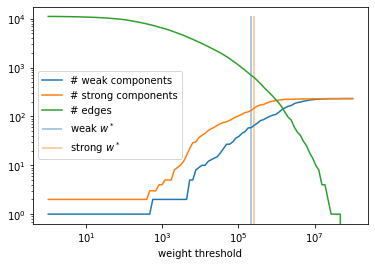

In [93]:
plt.loglog(thresholds, betti_0_weak, label="# weak components")
plt.loglog(thresholds, betti_0_strong, label="# strong components")
plt.loglog(thresholds, n_edges, label="# edges")
plt.vlines(w_weak, 0, n_edges[0], color="C0", alpha=0.5, label=r"weak $w^*$")
plt.vlines(w_strong, 0, n_edges[0], color="C1", alpha=0.5, label=r"strong $w^*$")
plt.xlabel("weight threshold")
plt.legend()
plt.show()

### Community Detection

Girvan-Newman algorithm: https://www.pnas.org/doi/epdf/10.1073/pnas.122653799

Modularity: https://arxiv.org/abs/cond-mat/0408187

Louvain algorithm: https://pure.unamur.be/ws/files/1384844/fast.pdf

Vienna Memetic Graph Clusterer: https://arxiv.org/abs/1802.07034

In [125]:
# with weight
partition = nx.algorithms.community.greedy_modularity_communities(G_2015, weight="weight")

for i, group in enumerate(partition):
    print("community", i, ":\n", list(countries.loc[group, "name"]), "\n")

community 0 :
 ['Martinique', 'Mauritania', 'Algeria', 'Andorra', 'Mayotte', 'Monaco', 'Argentina', 'Morocco', 'New Caledonia', 'Belgium', 'Bolivia (Plurinational State of)', 'Brazil', 'Paraguay', 'Peru', 'Cabo Verde', 'Portugal', 'Réunion', 'Romania', 'Chile', 'Colombia', 'Saint Pierre and Miquelon', 'Comoros', 'San Marino', 'Sao Tome and Principe', 'Senegal', 'Ecuador', 'Spain', 'Switzerland', 'France', 'French Guiana', 'French Polynesia', 'Gambia', 'Tunisia', 'Guadeloupe', 'Guinea-Bissau', 'Holy See', 'Uruguay', 'Vanuatu', 'Venezuela (Bolivarian Republic of)', 'Wallis and Futuna Islands', 'Western Sahara', 'Israel', 'Italy', 'Liechtenstein', 'Luxembourg', 'Madagascar'] 

community 1 :
 ['Marshall Islands', 'Mexico', 'Anguilla', 'Micronesia (Federated States of)', 'Antigua and Barbuda', 'Bahamas', 'Barbados', 'Belize', 'Nicaragua', 'Bermuda', 'Northern Mariana Islands', 'Palau', 'British Virgin Islands', 'Panama', 'Philippines', 'Puerto Rico', 'Canada', 'Cayman Islands', 'Republic of

In [126]:
# without weight
partition = nx.algorithms.community.greedy_modularity_communities(G_2015)

for i, group in enumerate(partition):
    print("community", i, ":\n", list(countries.loc[group, "name"]), "\n")

community 0 :
 ['Afghanistan', 'Algeria', 'Angola', 'Bahrain', 'Bangladesh', 'Belgium', 'Benin', 'Bhutan', 'Botswana', 'Burkina Faso', 'Burundi', 'Cabo Verde', 'Cameroon', 'Central African Republic', 'Chad', 'Comoros', 'Congo', "Côte d'Ivoire", 'Cyprus', 'Czech Republic', 'Democratic Republic of the Congo', 'Djibouti', 'Egypt', 'Equatorial Guinea', 'Eritrea', 'Ethiopia', 'France', 'Gabon', 'Gambia', 'Ghana', 'Guinea', 'Guinea-Bissau', 'India', 'Iraq', 'Italy', 'Jordan', 'Kenya', 'Kuwait', 'Lebanon', 'Lesotho', 'Liberia', 'Libya', 'Madagascar', 'Malawi', 'Maldives', 'Mali', 'Malta', 'Mauritania', 'Mauritius', 'Mayotte', 'Monaco', 'Morocco', 'Mozambique', 'Myanmar', 'Namibia', 'Nepal', 'Netherlands', 'Niger', 'Nigeria', 'Norway', 'Oman', 'Pakistan', 'Portugal', 'Qatar', 'Réunion', 'Russian Federation', 'Rwanda', 'Sao Tome and Principe', 'Saudi Arabia', 'Senegal', 'Seychelles', 'Sierra Leone', 'Somalia', 'South Africa', 'South Sudan', 'Spain', 'Sri Lanka', 'State of Palestine', 'Sudan', '